# Introduction

Gaming world has been set abuzz in last couple of years with slew of games that can be classified to the genre of battle royale games. Some of the prominent titles under this genre are Player Unknown Battle Ground (PUBG), Fortnite and Call of Duty. Battle royale is a specific category of games that is based on the core principle of last man or team surviving as the winner of the game. The motivation for this project is to analyse one of the popular title called PUBG. A single match of PUBG is played by 100 players. Players can join the match in 3 type of teams - Solo, Duo or in a team of 4. Each match starts with 100 players air dropping on to single island. The island consists of different areas or cities with deserted homes, streets or warehouses having supplies for survival. Supplies include guns, ammunitions, frags, first-aid kits, energy drinks etc.

In [151]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler,PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error,recall_score, make_scorer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import statsmodels.formula.api as smf
import seaborn as sns
%matplotlib inline

## Read the Data

In [152]:
pubg_data=pd.read_csv(r'D:\MDA Stuff\Into_to_Data_Science\pubg-finish-placement-prediction\train_V2.csv')
pubg_data.head()

pubg_data = pubg_data.drop(['Id','groupId','matchId'],axis='columns')
pubg_data2 = pubg_data.drop(['matchType'],axis='columns')           

## Correlation Heat Map

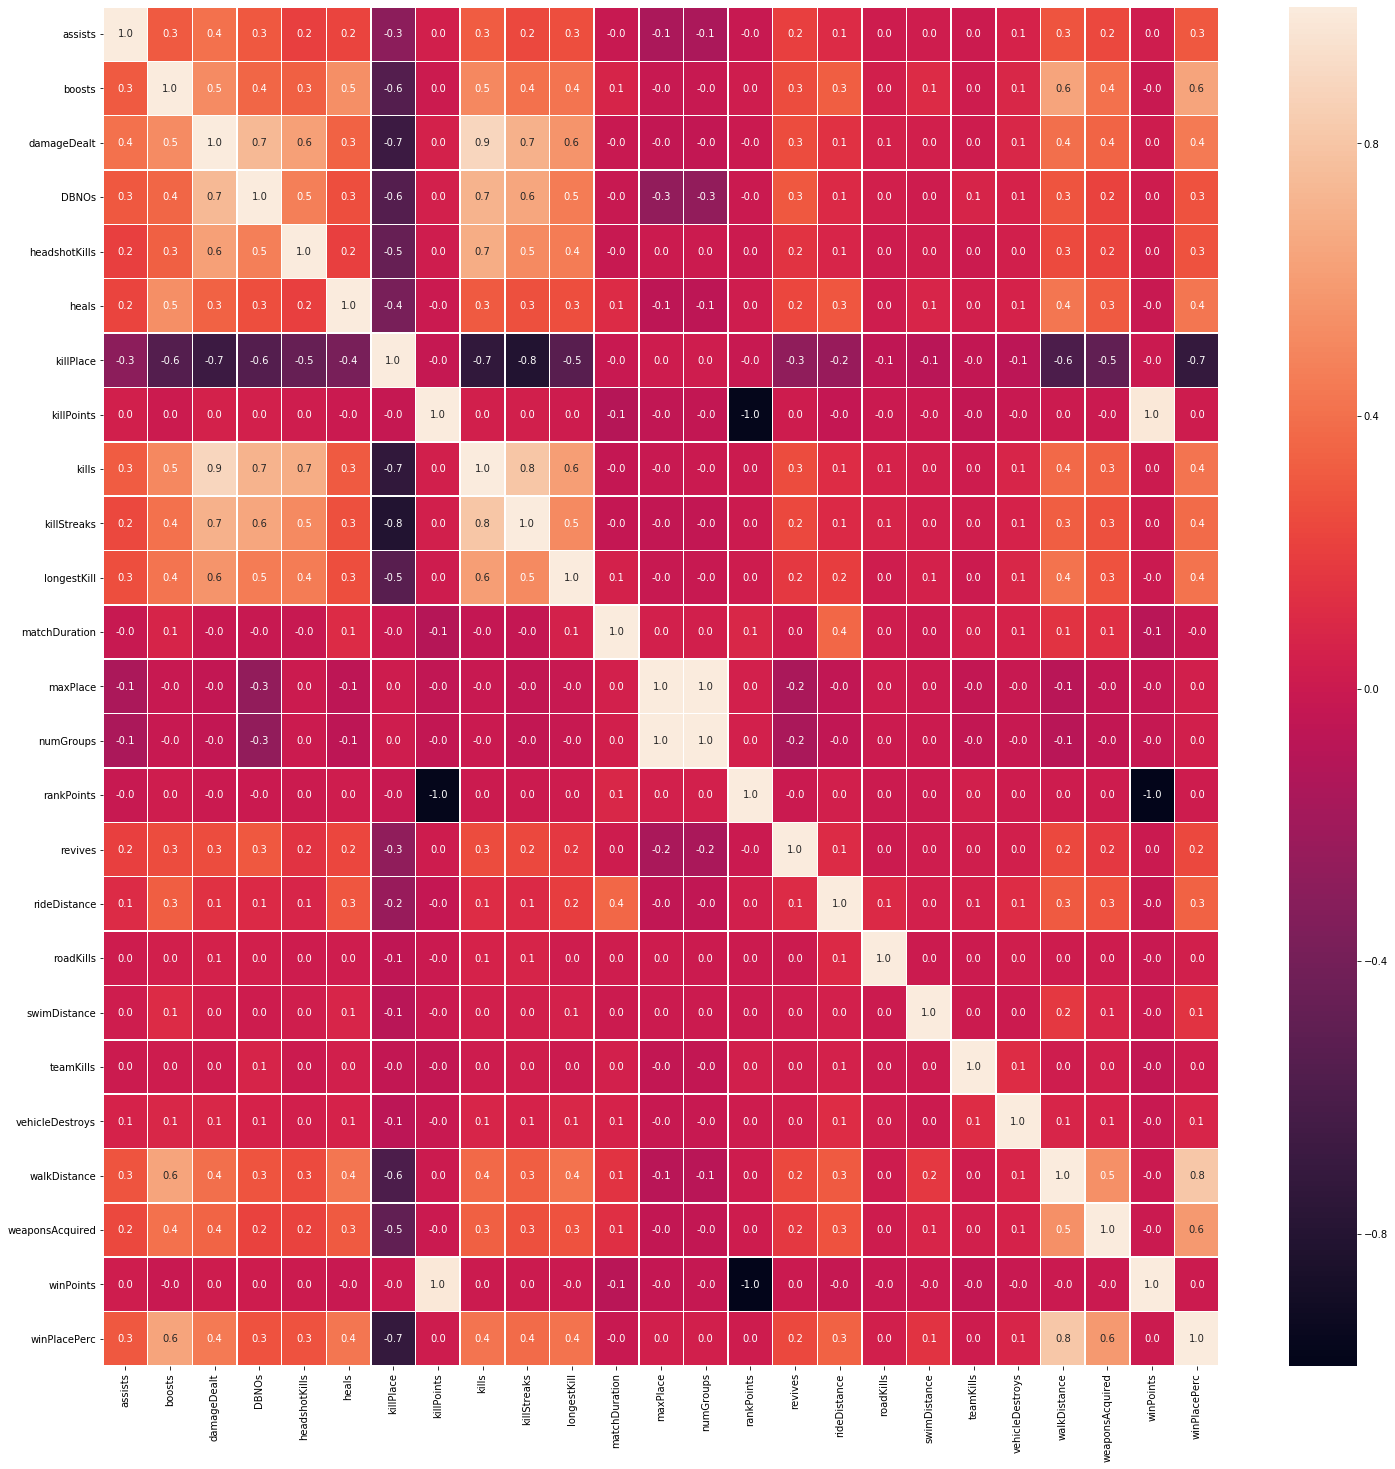

In [128]:
fig,ax = plt.subplots(figsize=(25, 25))
sns.heatmap(pubg_data2.corr(), annot=True, linewidths=.5, fmt= '.1f',ax=ax)
plt.show()

From the correlation heat map it can be seen that, there are following highly correlated pair of predictors:
1) kills and damageDealt
2) killPoints and winPoints
3) numGroups and maxPlace

## Data Preprocessing

The data was overall clean with only one entry with null value for response variable. That entry was removed. The data is further filtered down to hold only data from standard game modes of PUBG. Other modes are from events or custom matches.Records from other modes as events or custom matches will be removed.

In [153]:
print(f"Shape of original data:{pubg_data.shape}") 
# (4446966, 26)

pubg_data = pubg_data.loc[(pubg_data['matchType'].isin(['solo','duo','squad','solo-fpp','duo-fpp','squad-fpp']))]

# Also remove all entries where the response value in NaN
pubg_data = pubg_data.dropna(subset=['winPlacePerc'])

print(f"Shape of data with only standard game modes as match type:{pubg_data.shape}")
# (4411698, 26)

Shape of original data:(4446966, 26)
Shape of data with only standard game modes as match type:(4411698, 26)


## Standardize Data

Data is standandardized for further analysis

In [154]:
pubg_data_modified = pubg_data.drop('winPlacePerc', axis = 'columns').select_dtypes(include = [np.number])

col_name = pubg_data_modified.columns

for c in col_name :
    pubg_data[c] = (pubg_data_modified[c] - pubg_data_modified[c].mean())/pubg_data_modified[c].std()
    
pubg_data.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,...,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06,4.411698e+06
mean,6.397080e-15,-1.878553e-15,-4.199676e-13,-1.105812e-14,-1.362635e-14,1.220919e-15,1.208357e-16,-2.255853e-14,5.899629e-15,4.618128e-15,...,6.093660e-15,1.134614e-14,-3.453276e-15,-1.361044e-15,8.717170e-15,-1.171967e-14,-9.599945e-15,-1.328739e-14,-1.984233e-14,4.726383e-01
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,3.073011e-01
min,-4.010506e-01,-6.443990e-01,-7.808060e-01,-5.819080e-01,-3.818026e-01,-5.102405e-01,-1.701699e+00,-8.055251e-01,-6.073001e-01,-7.649314e-01,...,-3.489022e-01,-4.016172e-01,-4.633953e-02,-1.483435e-01,-1.423303e-01,-8.455093e-02,-9.742763e-01,-1.563205e+00,-8.205038e-01,0.000000e+00
25%,-4.010506e-01,-6.443990e-01,-7.808060e-01,-5.819080e-01,-3.818026e-01,-5.102405e-01,-8.641200e-01,-8.055251e-01,-6.073001e-01,-7.649314e-01,...,-3.489022e-01,-4.016172e-01,-4.633953e-02,-1.483435e-01,-1.423303e-01,-8.455093e-02,-8.437887e-01,-7.021110e-01,-8.205038e-01,2.000000e-01
50%,-4.010506e-01,-6.443990e-01,-2.743379e-01,-5.819080e-01,-3.818026e-01,-5.102405e-01,9.875217e-03,-8.055251e-01,-6.073001e-01,-7.649314e-01,...,-3.489022e-01,-4.016172e-01,-4.633953e-02,-1.483435e-01,-1.423303e-01,-8.455093e-02,-3.979349e-01,-2.715640e-01,-8.205038e-01,4.583000e-01
75%,-4.010506e-01,5.220193e-01,3.366252e-01,3.076621e-01,-3.818026e-01,2.389751e-01,8.474540e-01,1.062684e+00,5.888600e-02,6.470339e-01,...,-3.489022e-01,-4.016106e-01,-4.633953e-02,-1.483435e-01,-1.423303e-01,-8.455093e-02,6.954583e-01,5.895300e-01,1.200199e+00,7.407000e-01
max,2.063642e+01,1.860150e+01,2.214767e+01,2.788434e+01,4.398770e+01,2.945838e+01,1.903532e+00,2.647637e+00,2.137684e+01,2.465044e+01,...,8.248189e+01,2.702614e+01,2.770507e+02,1.153847e+02,2.394284e+01,5.491916e+01,2.079900e+01,1.000459e+02,1.900348e+00,1.000000e+00


## Distribution of data of different match type

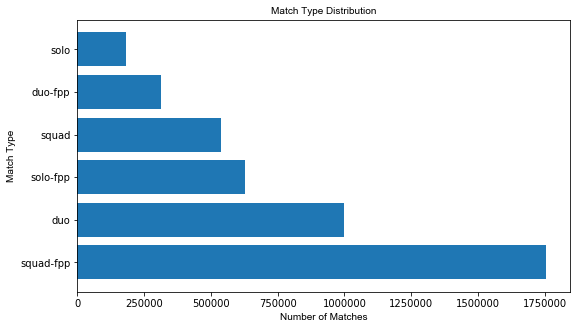

squad-fpp    1756186
duo-fpp       996691
squad         626526
solo-fpp      536761
duo           313591
solo          181943
Name: matchType, dtype: int64

In [131]:
pubg_matchType_dist = pubg_data.matchType.value_counts()

match_type = ['solo','duo','squad','solo-fpp','duo-fpp','squad-fpp']
plt.figure(figsize=(30,5))
axis_font = {'fontname':'Arial', 'size':'10'}
plt.subplot(131)
plt.barh(pubg_data.matchType.unique(), pubg_data.matchType.value_counts())
plt.title('Match Type Distribution',**axis_font)
plt.xlabel('Number of Matches',**axis_font)
plt.ylabel('Match Type',**axis_font)
plt.show()
pubg_matchType_dist

## See distribution of target variable winPlacePerc

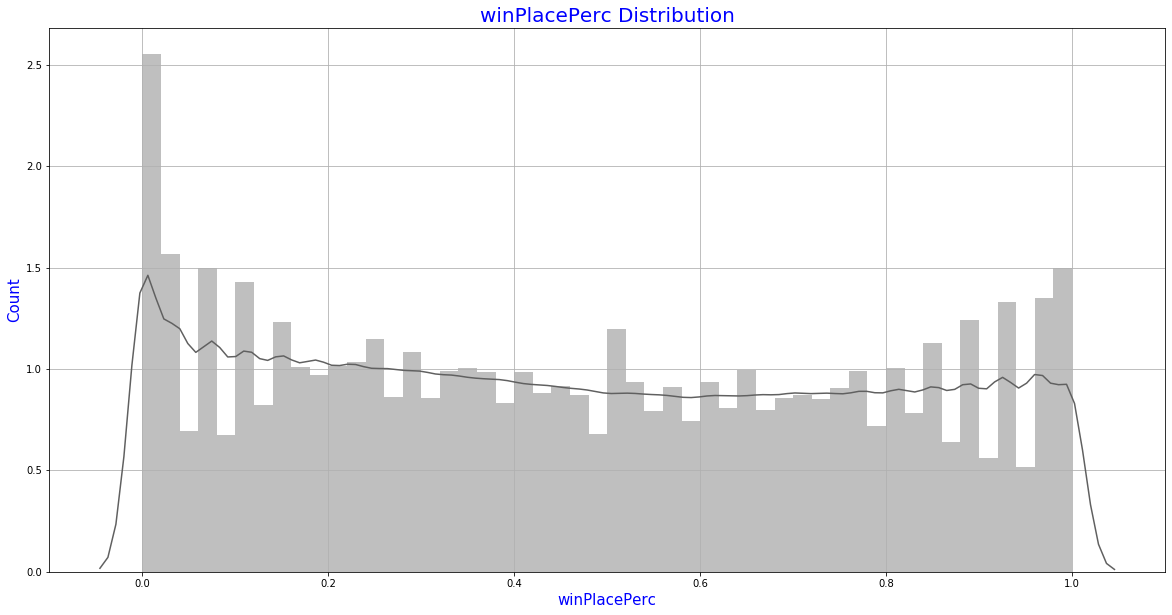

In [155]:
f,ax1 = plt.subplots(figsize =(20,10))
sns.distplot(pubg_data.winPlacePerc.values,color='#606060')
plt.xlabel('winPlacePerc',fontsize = 15,color='blue')
plt.ylabel('Count',fontsize = 15,color='blue')
plt.title('winPlacePerc Distribution',fontsize = 20,color='blue')
plt.grid()
plt.show()
# Not Normal distribution

The response variable for the dataset is not normally distributed. It is interesting to observe that that the highest peaks are at the extreme left and right of the plot. This means that there were always some players or squads that came first or last per match.

## Estimate Test Set Size, Training Size

For estimating the performance of model to within +/- 0.25 units using mean squared error as the loss function of choice. Appropriate size for test set :

In [156]:
winPlacePercVal = pubg_data.winPlacePerc * 100
losses = abs(winPlacePercVal - winPlacePercVal.median())
print(f"Mean of loss in %:{losses.mean()}")
print(f"Standard Deviation of loss in %:{losses.std()}")

Mean of loss in %:26.758902801237017
Standard Deviation of loss in %:15.177494879850785


Considering the test set size evaluated as 30%. We will evaluate a training set of 70%. The current dataset is too large to be managed due to environment limitations.

In [157]:
test_size_eval = round(((2*losses.std())/0.25)**2)
test_size_eval

train_size_eval = (test_size_eval/3)*7
train_size_eval
tot_scaled_down_data_size = test_size_eval + np.ceil(train_size_eval)
print(f"Total Scaled down data set size:{np.ceil(tot_scaled_down_data_size)}")
print(f"Training Data Size:{np.ceil(train_size_eval)}")
print(f"Test Data Size:{test_size_eval}")

Total Scaled down data set size:49144.0
Training Data Size:34401.0
Test Data Size:14743


## Sample Data

The data is scaled down to the calculated size above from the original size of 4411698 records. Due to hardware limitations it was difficult to analyse the complete set of data.

In [158]:
pubg_data = pubg_data.sample(int(tot_scaled_down_data_size),replace=True,random_state=1)
pubg_data.shape

(49144, 26)

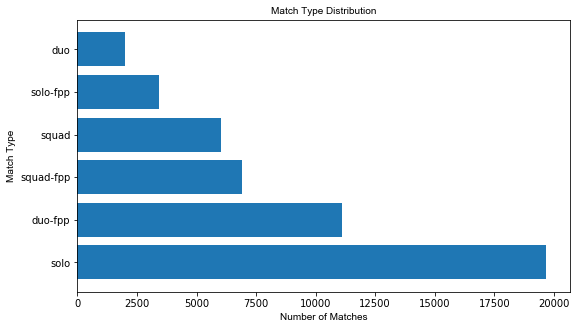

squad-fpp    19689
duo-fpp      11096
squad         6915
solo-fpp      6012
duo           3439
solo          1993
Name: matchType, dtype: int64

In [159]:
pubg_matchType_dist = pubg_data.matchType.value_counts()

match_type = ['solo','duo','squad','solo-fpp','duo-fpp','squad-fpp']
plt.figure(figsize=(30,5))
axis_font = {'fontname':'Arial', 'size':'10'}
plt.subplot(131)
plt.barh(pubg_data.matchType.unique(), pubg_data.matchType.value_counts())
plt.title('Match Type Distribution',**axis_font)
plt.xlabel('Number of Matches',**axis_font)
plt.ylabel('Match Type',**axis_font)
plt.show()
pubg_matchType_dist

It can be seen that the sampled data still has the similar proportional distribution as the original data for each match type category.

## Encode Categorical Variable

There is only one categorical variable in the data which is 'matchType'. The categorical variable is encoded and can be on following categories:

1) Solo : In this category of match type a player competes with other players or squads as an individual or solo member.

2) Squad : In this category of match type a group of four members compete as a squad.

3) Duo : In this category of match type a group of two members compete with other players as a squad.

3) Solo FPP : In this category of match type an individual compete in with other players or squads in first person view.

4) Duo FPP : In this category of match type a group of two members play as a squad in first person view.

5) Squad FPP : In this category of match type a group of four members play as a squad in first person view.

In [160]:
# In order to get dummies, convert categorical data to categorical type
pubg_data['matchType'] = pd.Categorical(pubg_data.matchType, categories=['solo','duo','squad','solo-fpp','duo-fpp','squad-fpp'])

pubg_data = pd.get_dummies(pubg_data,drop_first = True)
pubg_data.head(5)   

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,...,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc,matchType_duo,matchType_squad,matchType_solo-fpp,matchType_duo-fpp,matchType_squad-fpp
4356948,-0.401051,-0.061190,0.407899,-0.581908,-0.381803,-0.510240,-0.572788,-0.805525,0.058886,0.647034,...,-0.084551,-0.189070,1.450624,-0.820504,0.5652,0,0,0,0,0
3968803,-0.401051,-0.644399,-0.780806,-0.581908,-0.381803,-0.510240,1.284452,1.056318,-0.607300,-0.764931,...,-0.084551,-0.856204,-0.702111,1.244803,0.1875,0,0,0,1,0
495113,-0.401051,-0.644399,0.200721,0.307662,-0.381803,-0.510240,-0.900536,-0.805525,0.058886,0.647034,...,-0.084551,-0.445231,-0.271564,-0.820504,0.8571,0,0,0,0,1
4301832,4.858316,2.271647,4.937421,7.424223,6.444275,-0.135633,-1.701699,1.236137,5.388375,3.470964,...,-0.084551,0.790896,0.589530,1.197495,0.9231,0,1,0,0,0
1175514,-0.401051,-0.644399,-0.780806,-0.581908,-0.381803,-0.510240,0.701788,-0.805525,-0.607300,-0.764931,...,-0.084551,-0.736020,-0.702111,-0.820504,0.1852,0,0,0,0,1


## Baseline For Accuracy

In [ ]:
losses = abs(pubg_data.winPlacePerc - pubg_data.winPlacePerc.mean())
sns.distplot(losses)
print(losses.mean())


## Split Data into Test Set and Training Set

Data is split into testing and training set for model fitting and evaluation

In [162]:
y = pubg_data.winPlacePerc
X = pubg_data.drop('winPlacePerc', axis = 'columns')
# Random state assures that folds are consistent across models
Xtrain, Xtest, ytrain, ytest = train_test_split(X,
                                                y, 
                                                test_size = test_size_eval, 
                                                random_state = 0)

print(f"Size of train set after split:{Xtrain.shape}")
print(f"Size of test set after split:{Xtest.shape}")

(34401, 29) (14743, 29)


## Baseline For Test Accuracy

0.2670598007373608


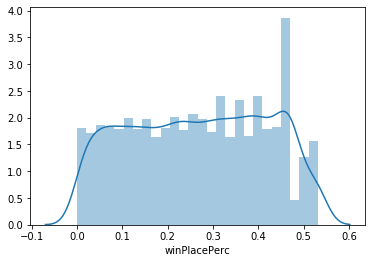

In [163]:
losses = abs(ytest - ytest.mean())
sns.distplot(losses)
print(losses.mean())

## Linear Regression

Simple linear model is fit on the training data set and the MSE for training is calculated using 5 fold cross validation.

In [ ]:
lin_model_pipeline = Pipeline([
    ('linear_regression', LinearRegression(normalize=False))
])

cv_score = cross_val_score(lin_model_pipeline, Xtrain, ytrain, cv=5, scoring='neg_mean_squared_error')
print(f"MSE for training from 5 fold cv for linear regression:{-cv_score.mean()}")

## Check Test Error for Linear Regression Model

MSE is used as the metric to evaluate the performance of the model on the test data. It can be seen that the MSE test is close to the MSE train which means that the model didn't overfit.

In [165]:
lin_model_pipeline.fit(Xtrain, ytrain)

ypred = lin_model_pipeline.predict(Xtest)

test_errors = ytest - ypred

mse = mean_squared_error(ytest, ypred)

print(f"MSE for testing for linear regression:{mse)}")

0.014388571057155415

## Linear Regression Coefficients

R square value of linear regression model:0.8450237085750254


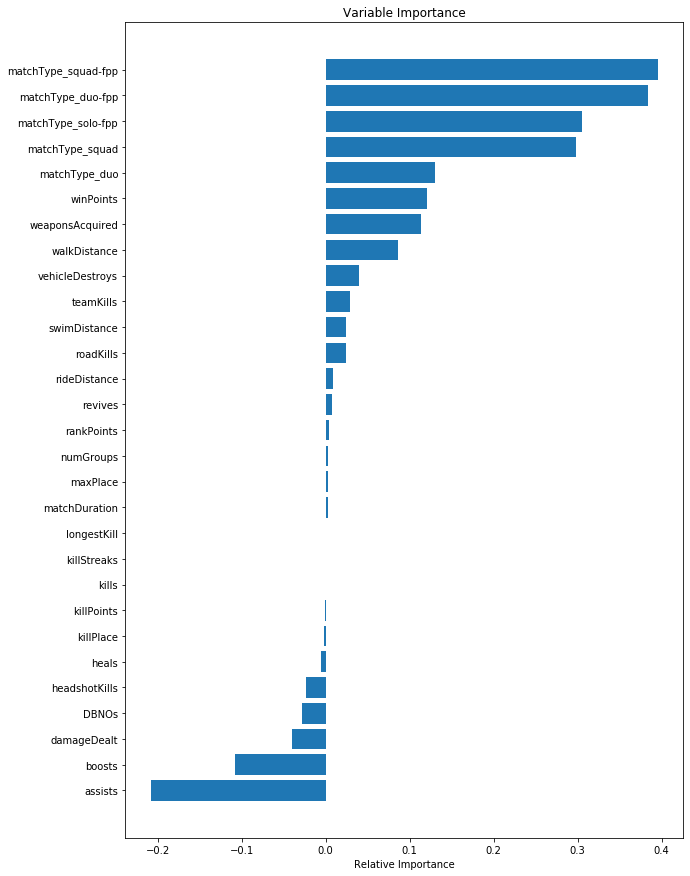

In [166]:
R_square = lin_model_pipeline.named_steps['linear_regression'].score(Xtrain,ytrain)
print(f"R square value of linear regression model:{R_square}")

pred_coef = lin_model_pipeline.named_steps['linear_regression'].coef_

f,ax1 = plt.subplots(figsize =(10,15))
sorted_idx = np.argsort(pred_coef)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, pred_coef[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

## Plot Predicted Values vs True Values (Linear Regression)

Text(0, 0.5, 'Predictions')

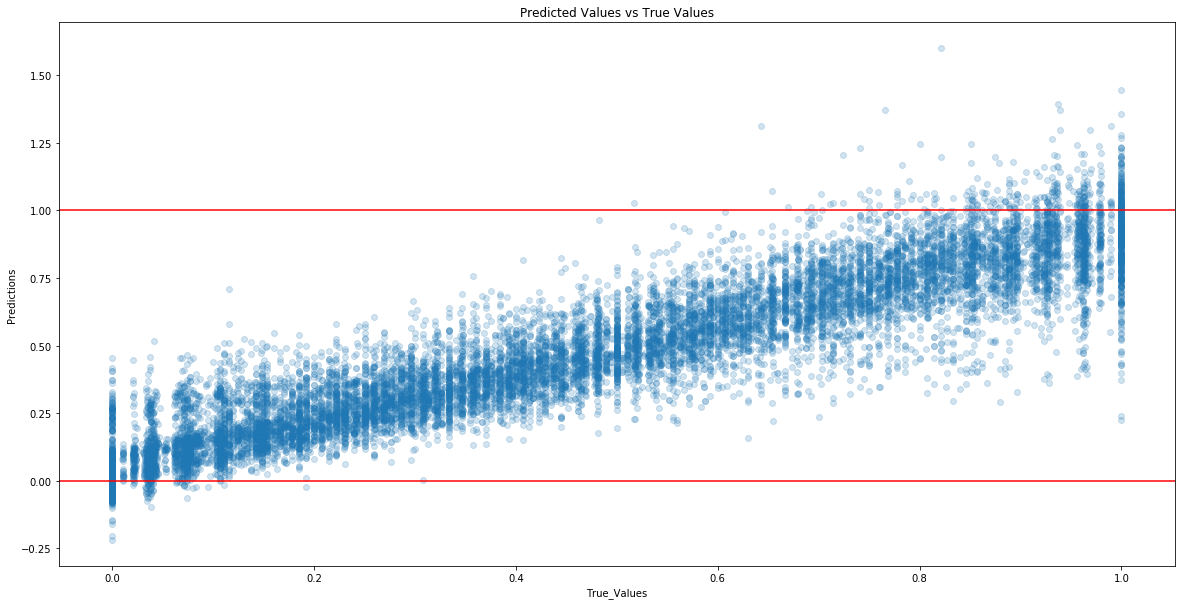

In [167]:
colors = ['b','g']
f,ax1 = plt.subplots(figsize =(20,10))
plt.scatter(ytest, ypred,alpha=0.2)
plt.title("Predicted Values vs True Values")
plt.xlabel('True_Values')
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=1.0, color='r', linestyle='-')
plt.ylabel('Predictions')

## Polynomial Regression 

In [169]:
poly_model = Pipeline([
        ('poly',PolynomialFeatures(include_bias=False)),
        ('linear_regression',LinearRegression(normalize=False))
        ])
cv_score_G = cross_val_score(poly_model,Xtrain,ytrain,cv=5,
                           scoring='neg_mean_squared_error')
print(-cv_score_G.mean())

0.008199456026953943


## Check Test Error for Polynomial Regression Model

In [170]:
poly_model.fit(Xtrain, ytrain)

ypred = poly_model.predict(Xtest)

test_errors = ytest - ypred

mse = mean_squared_error(ytest, ypred)

mse

0.008087870611003935

## Plot Test vs Predicted Values

Text(0, 0.5, 'Predictions')

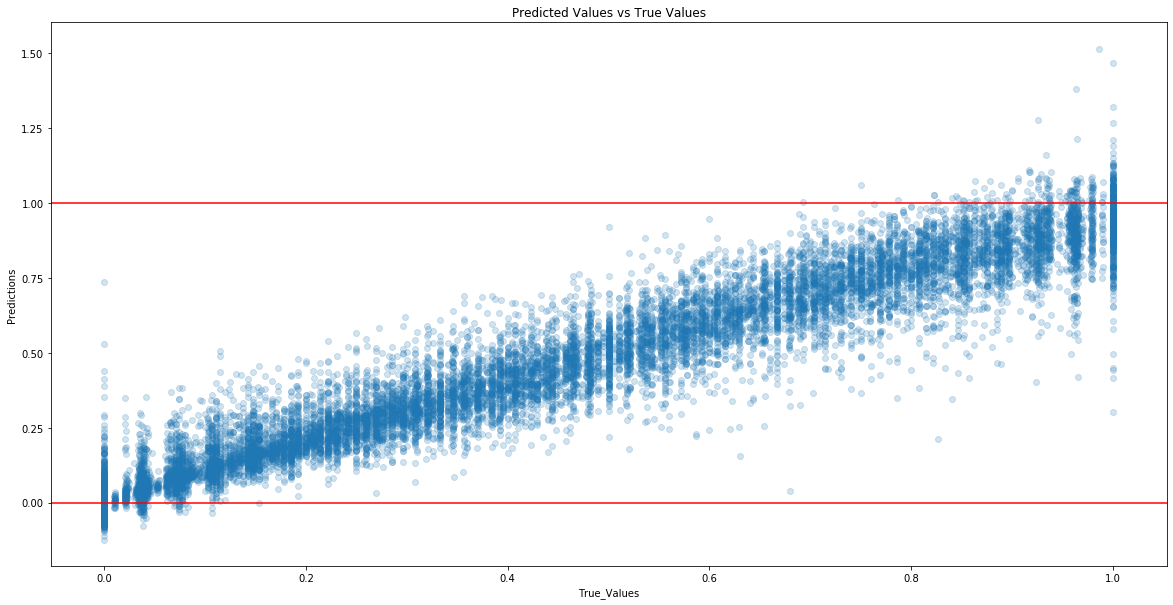

In [171]:
colors = ['b','g']
f,ax1 = plt.subplots(figsize =(20,10))
plt.scatter(ytest, ypred,alpha=0.2)
plt.title("Predicted Values vs True Values")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=1.0, color='r', linestyle='-')
plt.xlabel('True_Values')
plt.ylabel('Predictions')

## LASSO Regression

In [173]:
lasso_model_pipeline = Pipeline([
    ('lasso_regression', Lasso(max_iter=1000,tol=0.01,normalize=False))                   
])

params = [{'lasso_regression__alpha':np.arange(1e-5,10,0.1)}]

lasso_reg = GridSearchCV(lasso_model_pipeline,params,scoring='neg_mean_squared_error',cv=5)

best_param = lasso_reg.fit(Xtrain, ytrain)
print(f"Training Error:{-lasso_reg.best_score_}")
print(f"Best penalty factor:{lasso_reg.best_params_}")

Training Error:0.014727949182849111
Best penalty factor:{'lasso_regression__alpha': 1e-05}


## Calculate MAE for LASSO

In [174]:
ypred = lasso_reg.predict(Xtest)

test_errors = ytest - ypred

mse = mean_squared_error(ytest, ypred)

mse

0.014389845876588874

## Plot Test vs Predicted Values (LASSO)

Text(0, 0.5, 'Predictions')

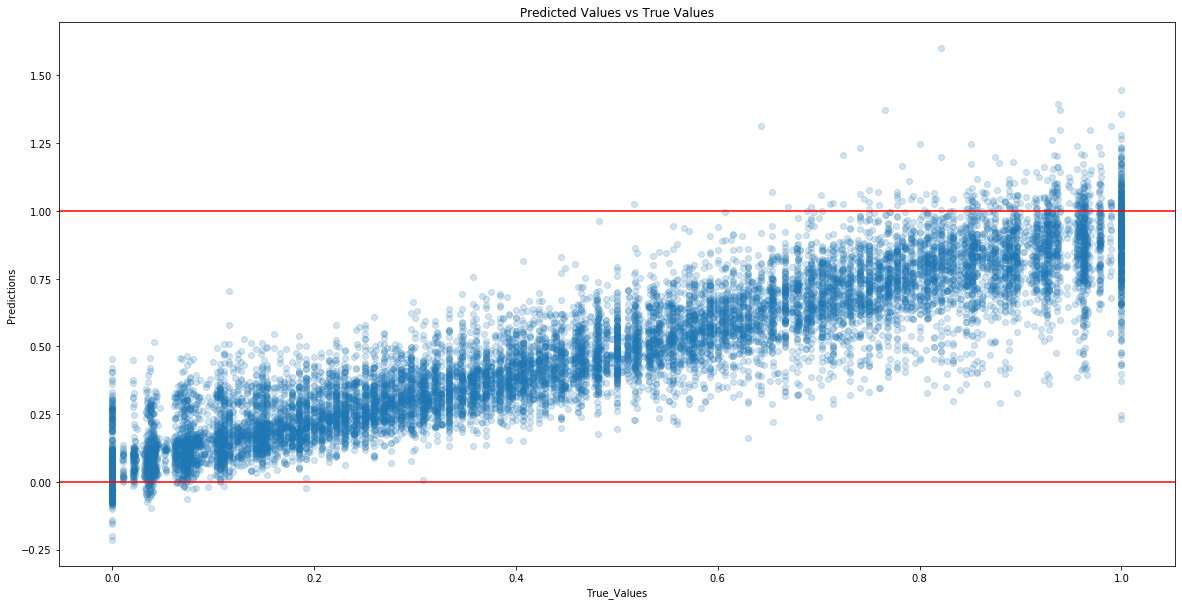

In [175]:
colors = ['b','g']
f,ax1 = plt.subplots(figsize =(20,10))
plt.scatter(ytest, ypred,alpha=0.2)
plt.title("Predicted Values vs True Values")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=1.0, color='r', linestyle='-')
plt.xlabel('True_Values')
plt.ylabel('Predictions')

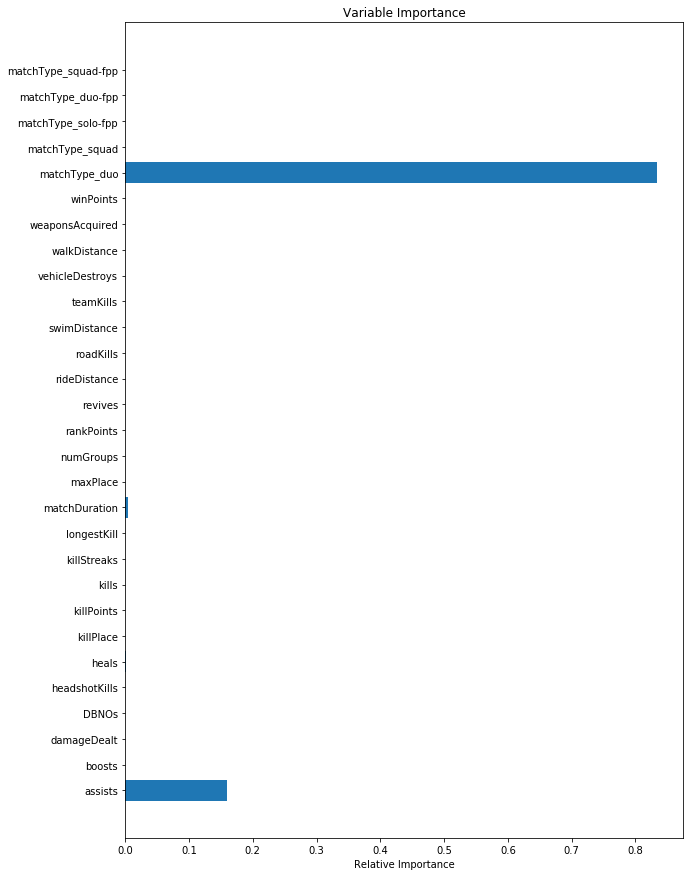

In [176]:
lm = lasso_reg.best_estimator_.named_steps['lasso_regression']
f,ax1 = plt.subplots(figsize =(10,15))
sorted_idx = np.argsort(lm.coef_)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

Polynomial Regression is performing the best for now as compared to LASSO and multiple linear regression

## Random Forest 

In [177]:
rf_pipeline = Pipeline([
        ('random_forest',RandomForestRegressor(random_state=1))
        ])
params = [{'random_forest__n_estimators':np.arange(100,1000,100),'random_forest__max_depth':np.arange(1,5,1)}]
rf_reg = GridSearchCV(rf_pipeline,params,scoring='neg_mean_squared_error',cv=5)
best_param = rf_reg.fit(Xtrain, ytrain)
rf_reg.best_score_
print(f"Training Error:{-rf_reg.best_score_}")
print(f"Best params:{rf_reg.best_params_}")

Training Error:0.015543011036296517
Best params:{'random_forest__max_depth': 4, 'random_forest__n_estimators': 300}


## Calculate MAE for Random Forest

In [179]:
ypred = rf_reg.predict(Xtest)

test_errors = ytest - ypred

mse = mean_squared_error(ytest, ypred)

mse

0.015037516675667679

## Plot Test vs Predicted Values (Random Forest)

Text(0, 0.5, 'Predictions')

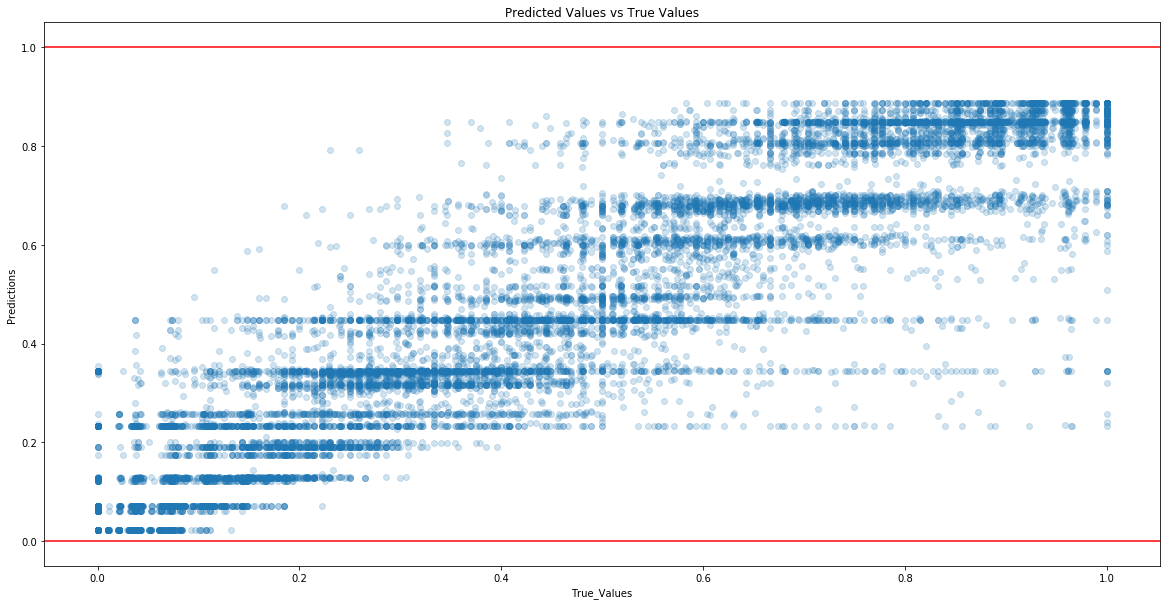

In [180]:
colors = ['b','g']
f,ax1 = plt.subplots(figsize =(20,10))
plt.scatter(ytest, ypred,alpha=0.2)
plt.title("Predicted Values vs True Values")
plt.axhline(y=0.0, color='r', linestyle='-')
plt.axhline(y=1.0, color='r', linestyle='-')
plt.xlabel('True_Values')
plt.ylabel('Predictions')

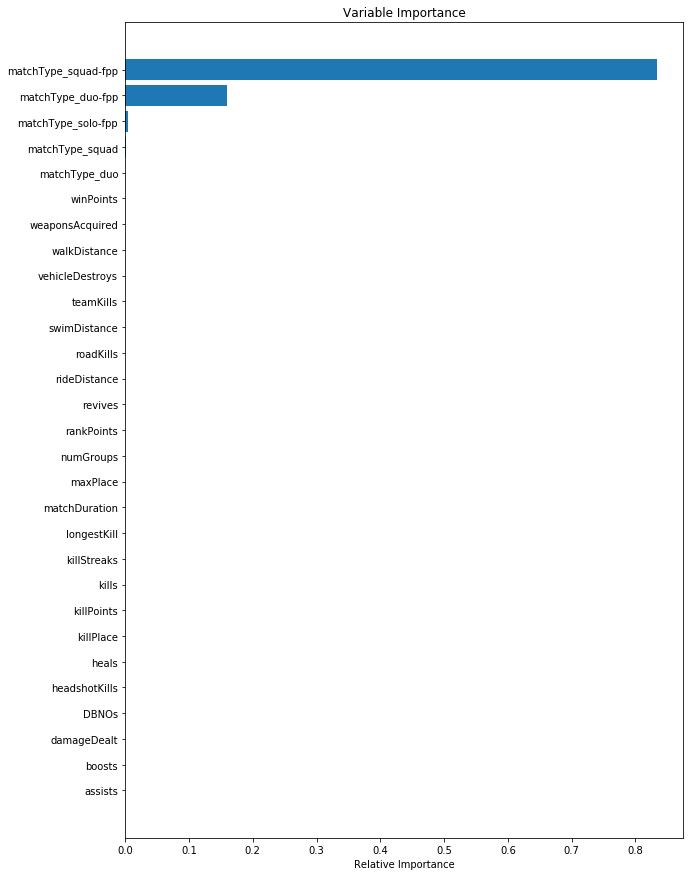

In [181]:
rf_best_model = RandomForestRegressor(max_depth=4,n_estimators=300)

feature_importance = rf_best_model.fit(Xtrain,ytrain).feature_importances_

# make importances relative to max importance
f,ax1 = plt.subplots(figsize =(10,15))
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xtrain.columns)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()